# Sine Potential

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from module.hamilton_class import HamiltonSystem
from module.plot_class import Plotter
from module.nambu_class import NambuSystem
from module.sampling import metropolis_hastings, sample_initial_conditions


# General parameters for different kinds of dynamics
k = 1.5 # spring constant
m = 1.0 # mass
suppression_factor = 50 # to suppress the effect of x^2 term
t_max = 30.0 # maximum time

potential = lambda x: k * (x**2) / suppression_factor - k * np.cos(x)

### Derivatives

In [2]:
# Hamiltonian dynamics
# H = p^2 / 2m + kx^2 / suppression_factor - k cos(x)
# x dot = dH / dp
# p dot = - dH / dx

def Hamilton_x_dot(x, p):
    return p / m  

def Hamilton_p_dot(x, p):
    return -2 * k * x / suppression_factor - k * np.sin(x)  

def Hamilton_H(x, p):
    return 0.5 * (p**2) / m + k * (x**2) / suppression_factor - k * np.cos(x)

# Nambu dynamics
# H = p^2 / 2m + kx^2 / factor - k cos(x) + r^2 / 2m
# G = r^2 / 2m + kx^2 / 2 / factor - k cos(x) / 2
# x dot = dH / dp * dG / dr - dH / dr * dG / dp
# p dot = dH / dr * dG / dx - dH / dx * dG / dr
# r dot = dH / dx * dG / dp - dH / dp * dG / dx

dHdx = lambda x: 2 * k * x / suppression_factor + k * np.sin(x)
dHdp = lambda p: p / m
dHdr = lambda r: r / m
dGdx = lambda x: k * x / suppression_factor + k * np.sin(x) / 2
dGdp = lambda p: 0
dGdr = lambda r: r / m


def Nambu_x_dot(x, p, r):
    val = dHdp(p) * dGdr(r) - dGdp(p)
    return val

def Nambu_p_dot(x, p, r):
    val = dHdr(r) * dGdx(x) - dHdx(x) * dGdr(r)
    return val

def Nambu_r_dot(x, p, r):
    val = dHdx(x) * dGdp(p) - dHdp(p) * dGdx(x)
    return val

def Nambu_H(x, p, r):
    val = 0.5 * (p**2) / m + k * (x**2) / suppression_factor - k * np.cos(x) + 0.5 * (r**2) / m
    return val

def Nambu_G(x, p, r):
    val = 0.5 * (r**2) / m + k * (x**2) / suppression_factor / 2 - k * np.cos(x) / 2
    return val



### Single initial condition using Hamiltonian System

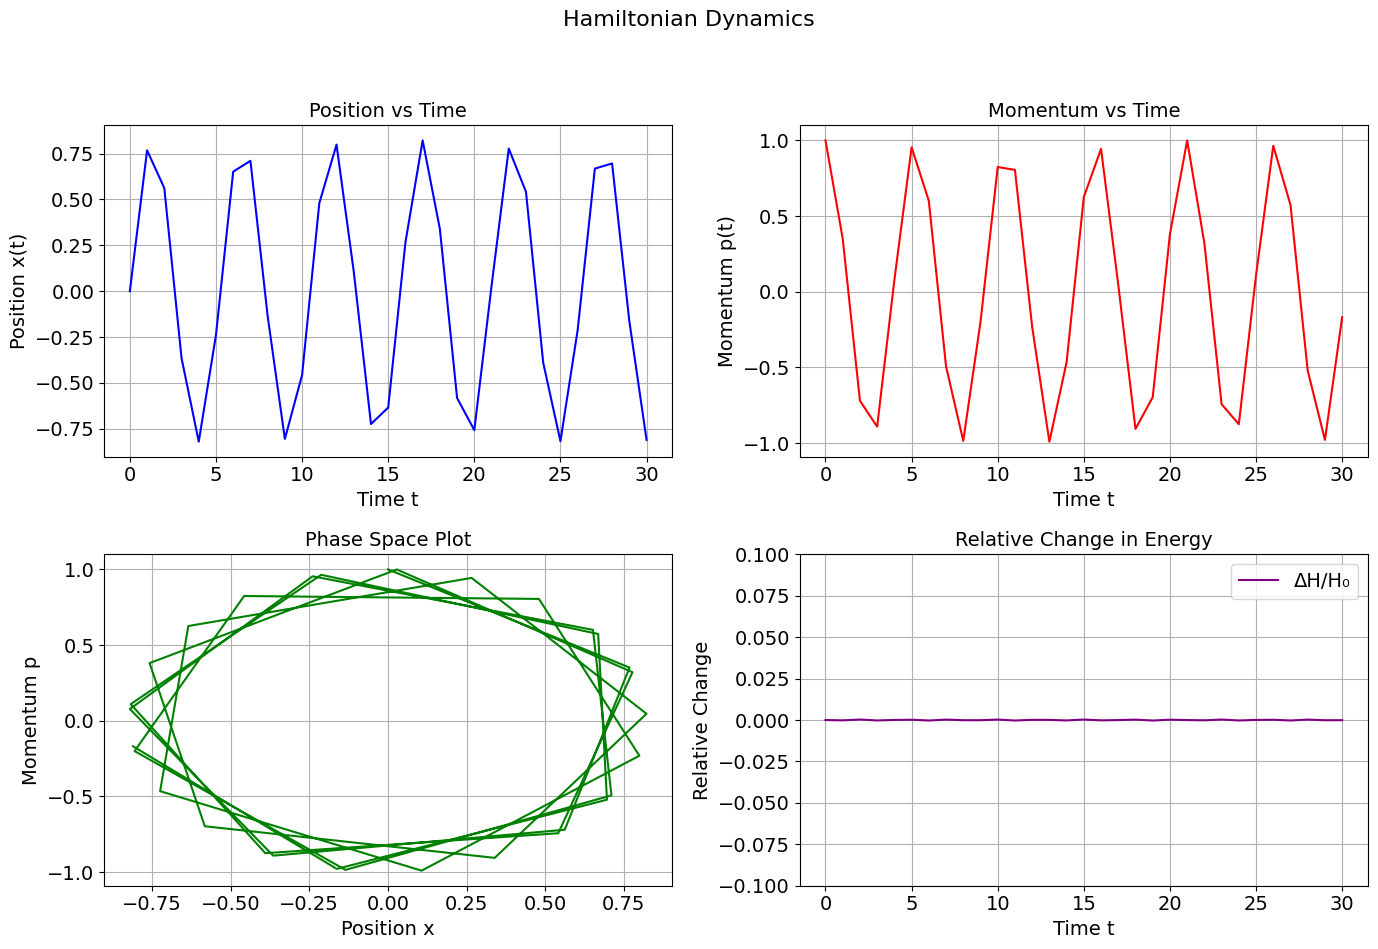

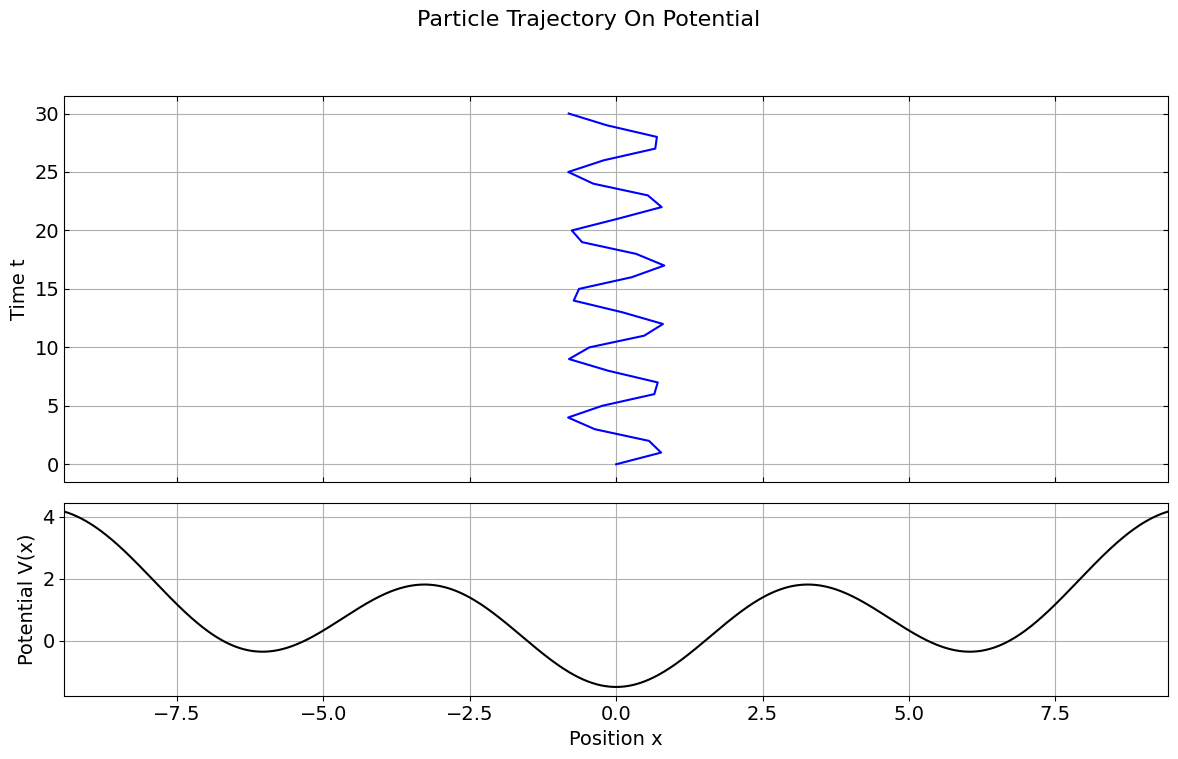

>>> Number of force calculation:  30000


In [3]:
# Define the parameters
delta_t = 0.001  # Time step
N_force = 0

# Fixed initial condition
x0, p0 = 0.0, 1.0

# Create Hamiltonian system
hamilton_system = HamiltonSystem(Hamilton_p_dot, Hamilton_x_dot, t_max, delta_t)

# Simulate for the fixed initial condition
t_array, x_array, p_array = hamilton_system.simulate(x0, p0)
N_force += len(t_array) - 1 # each time of simulate includes a dV / dx calculation

# Sample the data
t_sampled, x_sampled, p_sampled = hamilton_system.pick_data(t_array, x_array, p_array)

# Calculate energy
energy_sampled = Hamilton_H(x_sampled, p_sampled)

# Plotting
plotter = Plotter()
plotter.static_plots("Hamiltonian", t_sampled, x_sampled, p_sampled, energy_sampled)
plotter.trajectory_plot(x_sampled, t_sampled, potential)

print(">>> Number of force calculation: ", N_force)

### Single initial condition using Nambu System

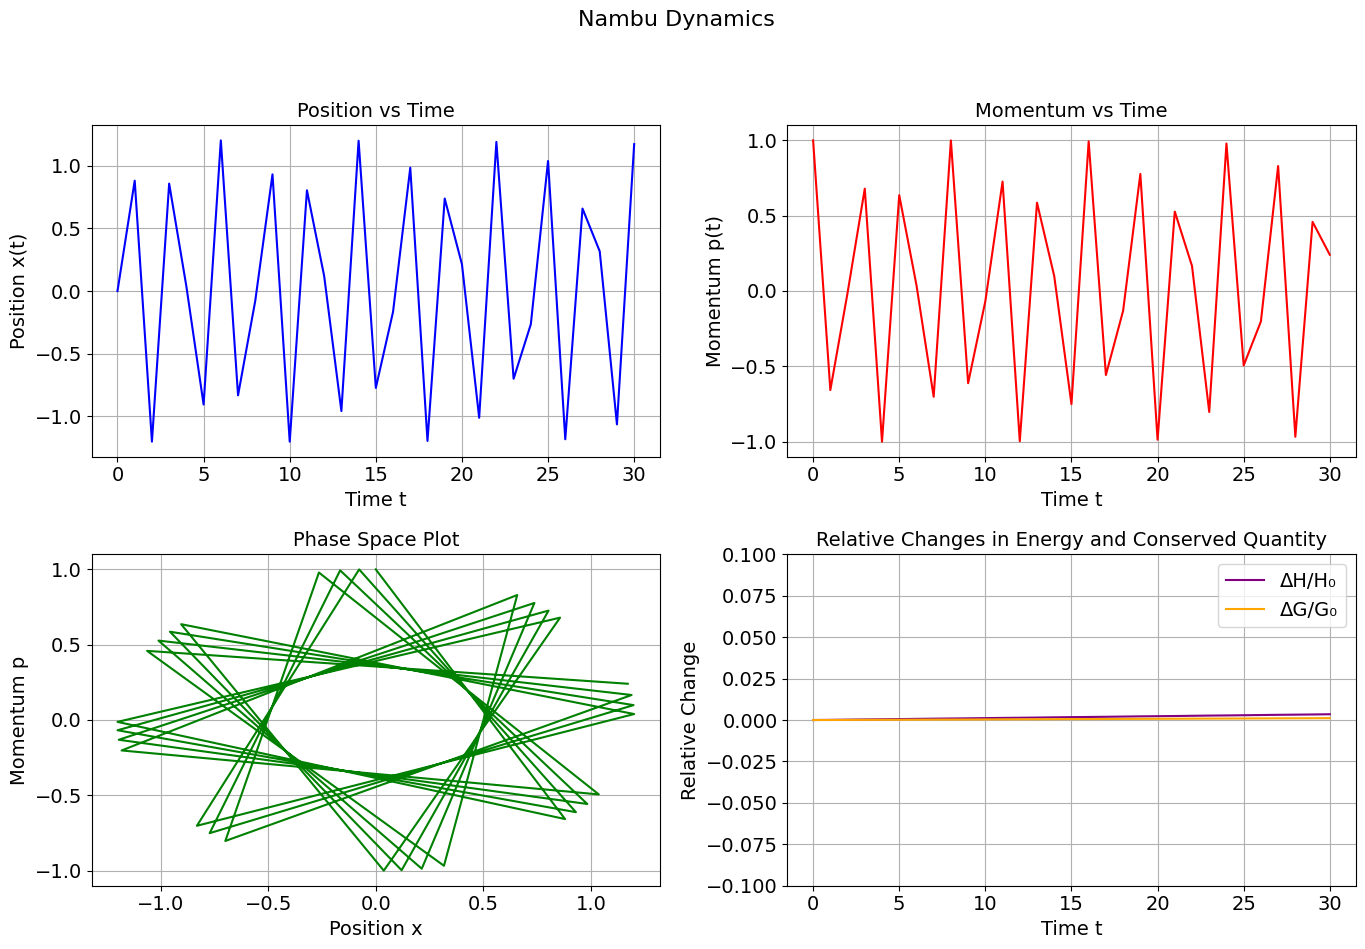

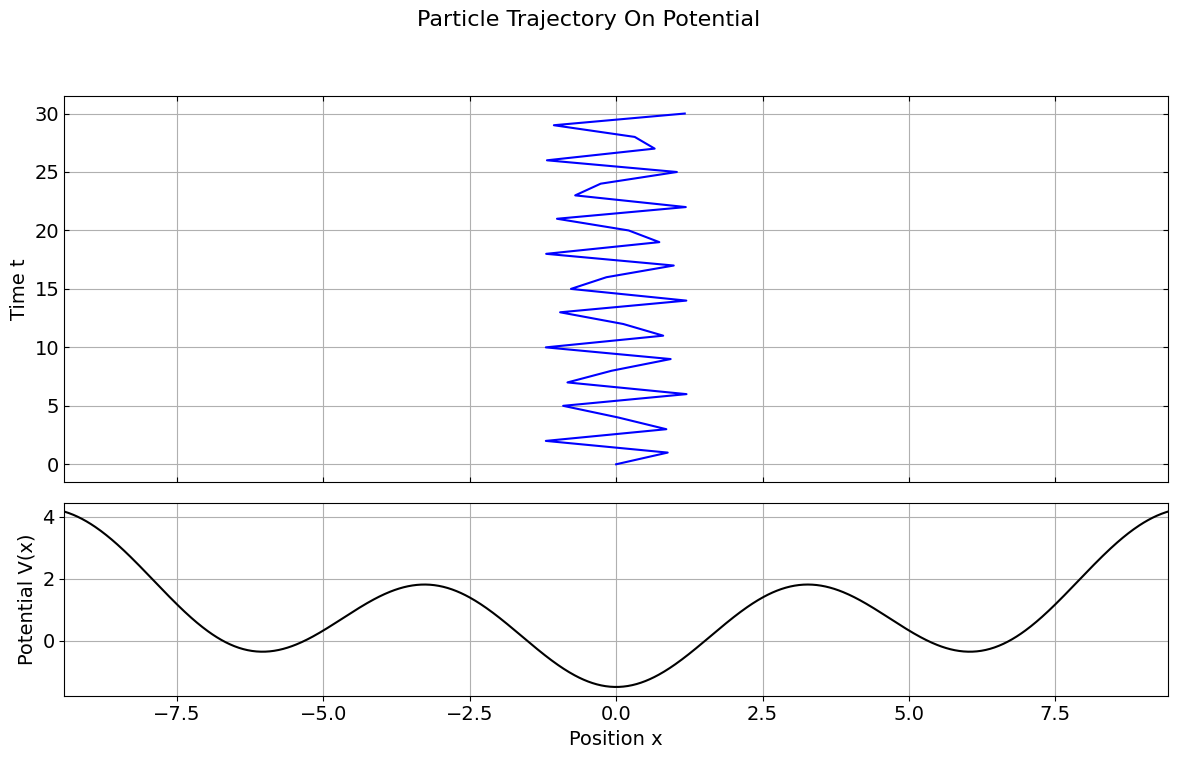

>>> Number of force calculation:  300000


In [4]:
# Define the parameters
delta_t = 0.0001  # Time step
N_force = 0

# Initial conditions
x0 = 0.0
p0 = 1.0
r0 = 3.0

# Create Hamiltonian system
nambu_system = NambuSystem(Nambu_x_dot, Nambu_p_dot, Nambu_r_dot, t_max, delta_t)

# Simulate for the fixed initial condition
t_array, x_array, p_array, r_array = nambu_system.simulate(x0, p0, r0)
N_force += len(t_array) - 1 # each time of simulate includes a dV / dx calculation

t_sampled, x_sampled, p_sampled, r_sampled = nambu_system.pick_data(t_array, x_array, p_array, r_array)

# Calculate energy
energy_sampled = Nambu_H(x_sampled, p_sampled, r_sampled)
conserved_G = Nambu_G(x_sampled, p_sampled, r_sampled)

# Plotting
plotter = Plotter()
plotter.static_plots("Nambu", t_sampled, x_sampled, p_sampled, energy_sampled, conserved_G)
plotter.trajectory_plot(x_sampled, t_sampled, potential)

print(">>> Number of force calculation: ", N_force)

### Sampling different initial conditions


>>> Generated 1500 sets of (p0, r0) satisfies p(p0, r0) ∝ exp(-H(p0, r0))


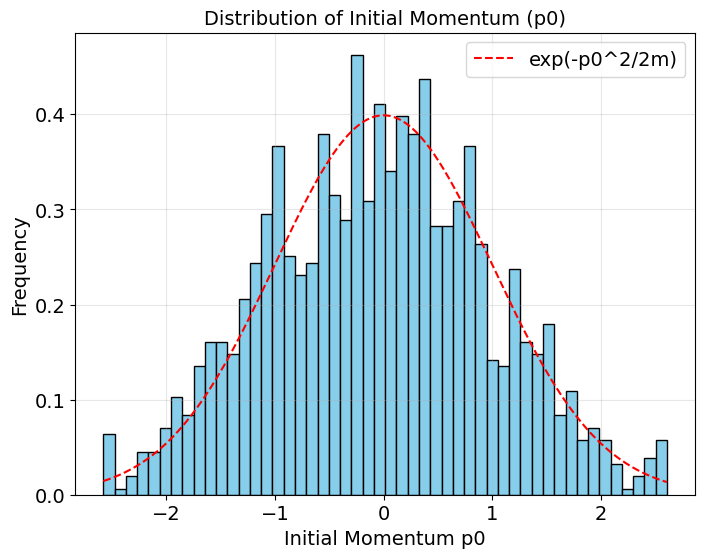

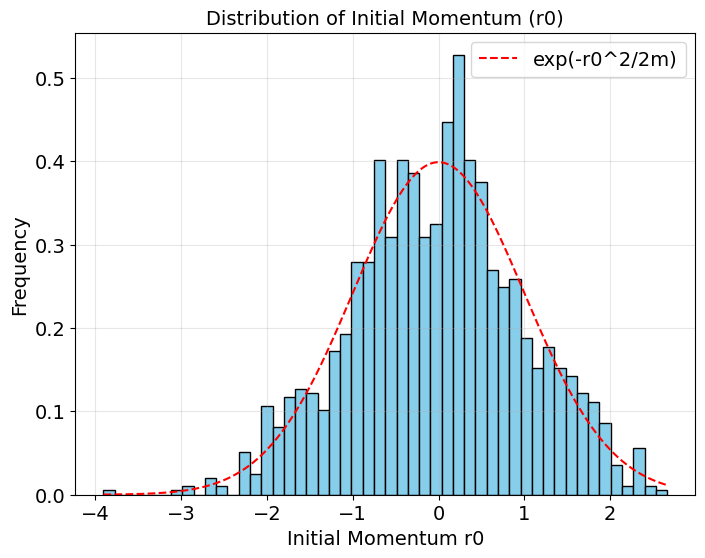

In [5]:
Nsamp = 1500
p_term = lambda p: p**2 / (2 * m)
r_term = lambda r: r**2 / (2 * m)

samples = sample_initial_conditions(Nsamp, p_term, r_term)
p0_samples, r0_samples = zip(*samples)
print(f"\n>>> Generated {Nsamp} sets of (p0, r0) satisfies p(p0, r0) ∝ exp(-H(p0, r0))")

# Create a histogram of p0_samples
plt.figure(figsize=(8, 6))
plt.hist(p0_samples, bins=50, color='skyblue', edgecolor='black', density=True)
# Add theoretical distribution line
x_range = np.linspace(min(p0_samples), max(p0_samples), 1000)
theoretical_dist = np.exp(-x_range**2 / 2 / m) / np.sqrt(2 * np.pi)  # Normalized Gaussian distribution
plt.plot(x_range, theoretical_dist, color='red', linestyle='--', label='exp(-p0^2/2m)')
plt.title("Distribution of Initial Momentum (p0)")
plt.xlabel("Initial Momentum p0")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Create a histogram of r0_samples
plt.figure(figsize=(8, 6))
plt.hist(r0_samples, bins=50, color='skyblue', edgecolor='black', density=True)
# Add theoretical distribution line
x_range = np.linspace(min(r0_samples), max(r0_samples), 1000)
theoretical_dist = np.exp(-x_range**2 / 2 / m) / np.sqrt(2 * np.pi)  # Normalized Gaussian distribution
plt.plot(x_range, theoretical_dist, color='red', linestyle='--', label='exp(-r0^2/2m)')
plt.title("Distribution of Initial Momentum (r0)")
plt.xlabel("Initial Momentum r0")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Calculate the Pcross(n; x0)

In [6]:
x_search = np.linspace(-50, 50, 10000)
potential_values = potential(x_search) # * think about use which potential
local_maxima_indices = (
    np.where(
        (potential_values[1:-1] > potential_values[:-2])
        & (potential_values[1:-1] > potential_values[2:])
    )[0]
    + 1
)
local_maxima = x_search[local_maxima_indices]
print(f"\n>>> Local maxima of the potential function at:", local_maxima)


>>> Local maxima of the potential function at: [-23.17731773 -16.42664266  -9.8259826   -3.27532753   3.27532753
   9.8259826   16.42664266  23.17731773]


>>> Using Hamiltonian Dynamics: 


Loop in samples:   0%|          | 0/1500 [00:00<?, ?it/s]

Loop in samples: 100%|██████████| 1500/1500 [02:51<00:00,  8.74it/s]


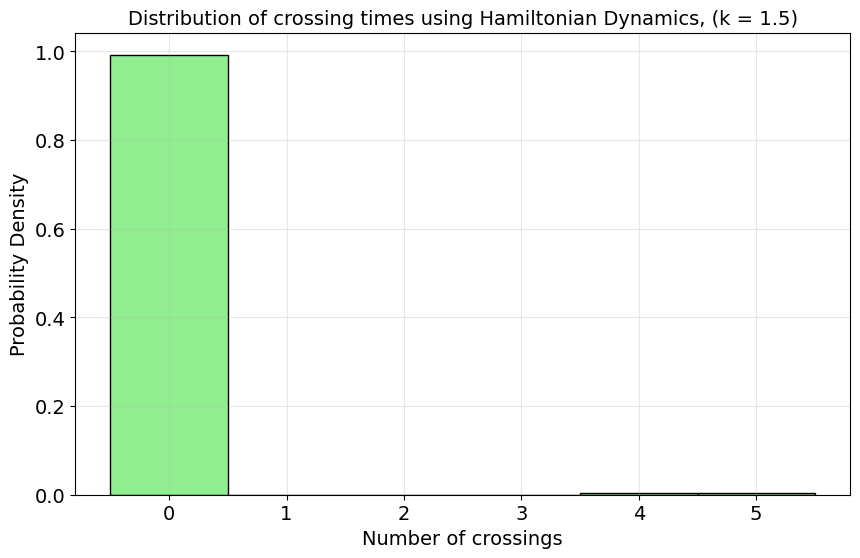

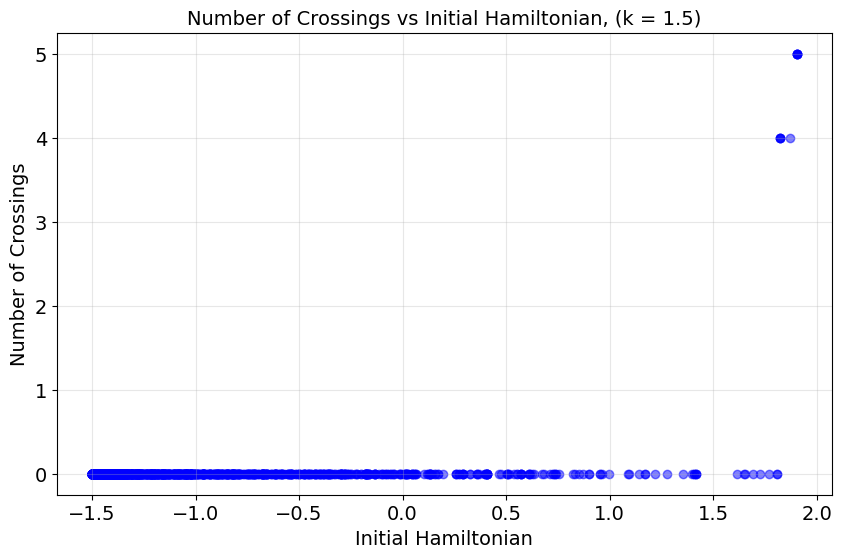

Average number of crossings: 0.0333


In [7]:
print(">>> Using Hamiltonian Dynamics: ")

# Define the parameters
delta_t = 0.001  # Time step

# Initial conditions
x0 = 0.0

hamilton_system = HamiltonSystem(Hamilton_p_dot, Hamilton_x_dot, t_max, delta_t)

times_of_crossing = []
for p0 in tqdm(p0_samples, desc="Loop in samples"):
    t_array, x_array, p_array = hamilton_system.simulate(x0, p0)

    # Count how many times the particle crosses the local maxima
    crossings = 0
    for i in range(1, len(x_array)):
        for max_x in local_maxima:
            if (x_array[i-1] - max_x) * (x_array[i] - max_x) < 0:
                crossings += 1
    times_of_crossing.append(crossings)

# Create histogram of displacements
plt.figure(figsize=(10, 6))
bins = np.arange(min(times_of_crossing), max(times_of_crossing) + 2) - 0.5
plt.hist(times_of_crossing, bins=bins, color='lightgreen', edgecolor='black', density=True)
plt.title(f"Distribution of crossing times using Hamiltonian Dynamics, (k = {k})")
plt.xlabel("Number of crossings")
plt.ylabel("Probability Density")
plt.grid(True, alpha=0.3)
plt.show()


# Calculate initial Hamiltonian values
initial_H = [Hamilton_H(x0, p0) for p0 in p0_samples]

# Create scatter plot of times_of_crossing vs initial H
plt.figure(figsize=(10, 6))
plt.scatter(initial_H, times_of_crossing, alpha=0.5, color='blue')
plt.title(f"Number of Crossings vs Initial Hamiltonian, (k = {k})")
plt.xlabel("Initial Hamiltonian")
plt.ylabel("Number of Crossings")
plt.grid(True, alpha=0.3)
plt.show()


# Calculate and print the average number of crossings
avg_max_displacement = np.mean(times_of_crossing)
print(f"Average number of crossings: {avg_max_displacement:.4f}")


>>> Using Nambu Dynamics: 


Loop in samples: 100%|██████████| 1500/1500 [54:04<00:00,  2.16s/it]


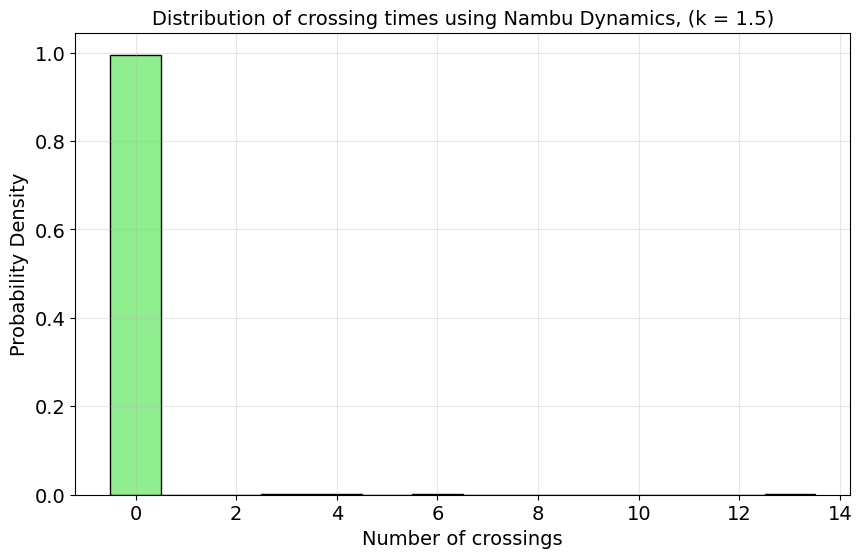

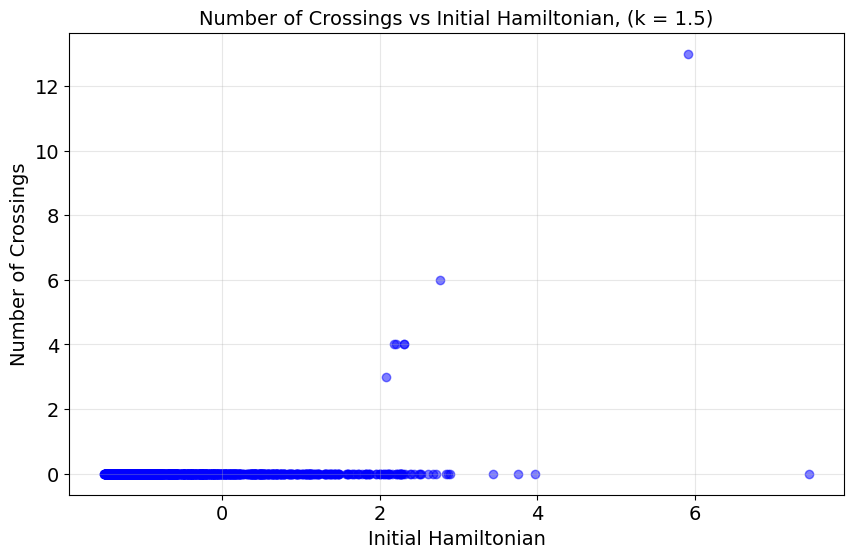

Average number of crossings: 0.0253


In [8]:
print(">>> Using Nambu Dynamics: ")

# Define the parameters
delta_t = 0.0001  # Time step

# Initial conditions
x0 = 0.0

nambu_system = NambuSystem(Nambu_x_dot, Nambu_p_dot, Nambu_r_dot, t_max, delta_t)

times_of_crossing = []
for p0, r0 in tqdm(zip(p0_samples, r0_samples), desc="Loop in samples", total=len(p0_samples)):
    t_array, x_array, p_array, r_array = nambu_system.simulate(x0, p0, r0)

    # Count how many times the particle crosses the local maxima
    crossings = 0
    for i in range(1, len(x_array)):
        for max_x in local_maxima:
            if (x_array[i-1] - max_x) * (x_array[i] - max_x) < 0:
                crossings += 1
    times_of_crossing.append(crossings)

# Create histogram of displacements
plt.figure(figsize=(10, 6))
bins = np.arange(min(times_of_crossing), max(times_of_crossing) + 2) - 0.5
plt.hist(times_of_crossing, bins=bins, color='lightgreen', edgecolor='black', density=True)
plt.title(f"Distribution of crossing times using Nambu Dynamics, (k = {k})")
plt.xlabel("Number of crossings")
plt.ylabel("Probability Density")
plt.grid(True, alpha=0.3)
plt.show()

# Calculate initial Hamiltonian values
initial_H = [Nambu_H(x0, p0, r0) for p0, r0 in zip(p0_samples, r0_samples)]

# Create scatter plot of times_of_crossing vs initial H
plt.figure(figsize=(10, 6))
plt.scatter(initial_H, times_of_crossing, alpha=0.5, color='blue')
plt.title(f"Number of Crossings vs Initial Hamiltonian, (k = {k})")
plt.xlabel("Initial Hamiltonian")
plt.ylabel("Number of Crossings")
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print the average maximum displacement
avg_max_displacement = np.mean(times_of_crossing)
print(f"Average number of crossings: {avg_max_displacement:.4f}")



### Test